In [21]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
import requests
from dotenv import load_dotenv

load_dotenv()


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [ ]:
# denne er bra - kan hente inspo herfra
# https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#part-3-conditional-interrupt

In [22]:
query="todos"
res = requests.get(f'http://jsonplaceholder.typicode.com/{query}')

res = res.json()[:10]

## make some tools

In [23]:
from langchain_core.tools import tool
from langchain_core.tools import ToolException
from langchain_community.tools import TavilySearchResults


@tool("api_call")
def api_call(query: str):
    """Searches for todo lists. Useful for searching for todo lists."""
    try :
        # res = requests.get(f'http://jsonplaceholder.typicode.com/{query}')
        res = requests.get(f'http://jsonplaceholder.typicode.com/todos')
        res = res.json()
        # maybe parse it?
        # res = parse_tickets_from_json(res)
        return res
    except Exception as e:
        raise ToolException(e)


@tool("multiply")
def multiply(x: int, y: int):
    """Multiplies two numbers."""
    return x * y

# web_search = TavilySearchResults(
#     max_results=2,
#     search_depth="advanced",
#     include_answer=True,
#     include_raw_content=True,
# )

@tool("web_search")
def web_search(query: str):
    """
    Searches the web using TavilySearchResults. Useful for performing web searches with advanced settings.
    """
    try:
        search = TavilySearchResults(
            max_results=2,
            search_depth="advanced",
            include_answer=True,
            include_raw_content=True,
        )
        results = search.invoke(query)
        return results
    except Exception as e:
        raise ToolException(e)


@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

In [24]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [25]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0
)

tools=[
    api_call,
    multiply,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)


oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

In [26]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"
    
tool_str_to_func = {
    "api_call": api_call,
    "multiply": multiply,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # generic tool-runner
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [27]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("api_call", run_tool)
graph.add_node("multiply", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        print(f"Adding edge from {tool_obj.name} to oracle")
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

Adding edge from api_call to oracle
Adding edge from multiply to oracle
Adding edge from web_search to oracle


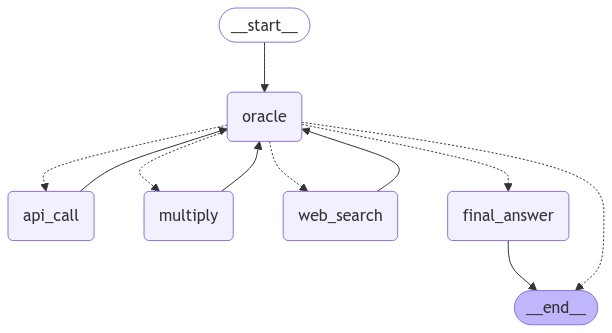

In [28]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
# out = runnable.invoke({
#     "input": "tell me something interesting about dogs",
#     "chat_history": [],
# })

In [30]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [31]:
out = runnable.invoke({
    "input": "list the first five items on my todo list",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
api_call.invoke(input={'query': 'first five items on my todo list'})
run_oracle
intermediate_steps: [AgentAction(tool='api_call', tool_input={'query': 'first five items on my todo list'}, log='TBD'), AgentAction(tool='api_call', tool_input={'query': 'first five items on my todo list'}, log="[{'userId': 1, 'id': 1, 'title': 'delectus aut autem', 'completed': False}, {'userId': 1, 'id': 2, 'title': 'quis ut nam facilis et officia qui', 'completed': False}, {'userId': 1, 'id': 3, 'title': 'fugiat veniam minus', 'completed': False}, {'userId': 1, 'id': 4, 'title': 'et porro tempora', 'completed': True}, {'userId': 1, 'id': 5, 'title': 'laboriosam mollitia et enim quasi adipisci quia provident illum', 'completed': False}, {'userId': 1, 'id': 6, 'title': 'qui ullam ratione quibusdam voluptatem quia omnis', 'completed': False}, {'userId': 1, 'id': 7, 'title': 'illo expedita consequatur quia in', 'completed': False}, {'userId': 1, 'id': 8, 'title': 'quo adipis

In [32]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
You requested the first five items on your todo list. Here is the information you need.

RESEARCH STEPS
--------------
1. Queried the todo list database for the first five items.
2. Retrieved the relevant data from the database.
3. Compiled the information into a readable format.

REPORT
------
The first five items on your todo list are as follows:

1. **Title:** delectus aut autem
   **Completed:** No

2. **Title:** quis ut nam facilis et officia qui
   **Completed:** No

3. **Title:** fugiat veniam minus
   **Completed:** No

4. **Title:** et porro tempora
   **Completed:** Yes

5. **Title:** laboriosam mollitia et enim quasi adipisci quia provident illum
   **Completed:** No

CONCLUSION
----------
These are the first five items on your todo list, including their titles and completion status. If you need further assistance, feel free to ask.

SOURCES
-------
- Internal todo list database

